In [240]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import cv2
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [184]:
import json
import os
from mpl_toolkits import mplot3d


In [9]:
import imp
import box_hunter as bh
imp.reload(bh)

<module 'box_hunter' from '/home/angiebird/code/cs231a/box_hunter/box_hunter.py'>

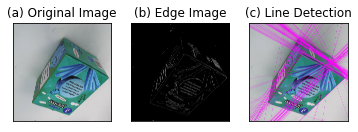

In [10]:
bh.test_edge_detector()

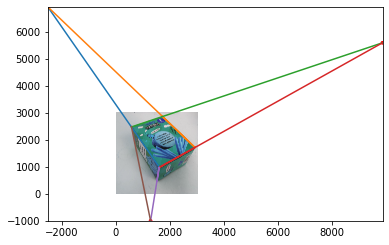

In [5]:
filename = "dataset/snack1.json"
box = bh.Box(filename)
box.show_vanishing_points()

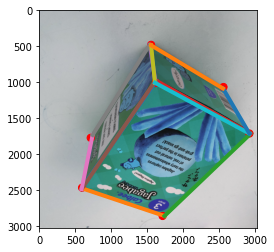

In [6]:
box.augment()

In [7]:
box.get_camera_matrix()
box.assign_plane_corner_indices()

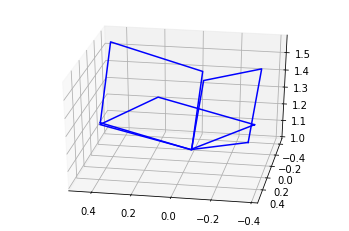

In [8]:
box.show_3d_reconstruction()